In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import DeLASE
from delase.metrics import mase
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import torch
from tqdm.auto import tqdm

from UniversalUnconsciousness.data_utils import get_grid_params_to_use, find_noisy_data, get_noise_filter_info
from UniversalUnconsciousness.hdf5_utils import *
from UniversalUnconsciousness.iaaft import surrogates
from UniversalUnconsciousness.plot_utils import *

load_font()
plt.style.use('UniversalUnconsciousness.sci_style')

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
# all_data_dir = '/orcd/data/ekmiller/001/common/datasets'
# data_class = 'propofolPuffTone'
data_class = 'anesthesiaLvrOdd'

In [5]:
# propofol dir
if data_class == 'propofolPuffTone':
    data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', data_class)
    cfg.params.data_class = 'propofolPuffTone'
    cfg.params.grid_set = 'grid_set6'
else:
    data_dir = os.path.join(cfg.params.all_data_dir, data_class, 'mat')
    cfg.params.data_class = 'anesthesiaLvrOdd'
    cfg.params.grid_set = 'grid_set6'


In [6]:
{'Mary': {'high': ['Mary-Anesthesia-20160818-02', 'Mary-Anesthesia-20160822-02', 'Mary-Anesthesia-20160809-01', 'Mary-Anesthesia-20160908-02', 'Mary-Anesthesia-20160902-02', 'Mary-Anesthesia-20160912-02', 'Mary-Anesthesia-20160916-02', 'Mary-Anesthesia-20160826-02', 'Mary-Anesthesia-20160914-02', 'Mary-Anesthesia-20160831-02']}, 'MrJones': {'high': ['MrJones-Anesthesia-20160125-01', 'MrJones-Anesthesia-20160210-01', 'MrJones-Anesthesia-20160121-01', 'MrJones-Anesthesia-20160301-01', 'MrJones-Anesthesia-20160105-01', 'MrJones-Anesthesia-20160201-01', 'MrJones-Anesthesia-20160113-01', 'MrJones-Anesthesia-20160206-01', 'MrJones-Anesthesia-20160107-01', 'MrJones-Anesthesia-20160123-01', 'MrJones-Anesthesia-20160109-01']}}
{'SPOCK': {'low': ['SPOCK_Ketamine_20210907', 'SPOCK_Ketamine_20210831', 'SPOCK_Ketamine_20210827', 'SPOCK_Ketamine_20210826', 'SPOCK_Ketamine_20210804', 'SPOCK_Ketamine_20210802', 'SPOCK_Ketamine_20210902'], 'high': ['SPOCK_Ketamine_20210727', 'SPOCK_Ketamine_20210712', 'SPOCK_Ketamine_20210707', 'SPOCK_Ketamine_20210719', 'SPOCK_Ketamine_20210715', 'SPOCK_Ketamine_20210909']}, 'PEDRI': {'low': ['PEDRI_Ketamine_20220215', 'PEDRI_Ketamine_20220211', 'PEDRI_Ketamine_20220224', 'PEDRI_Ketamine_20220128', 'PEDRI_Ketamine_20220425', 'PEDRI_Ketamine_20220228'], 'high': ['PEDRI_Ketamine_20220106', 'PEDRI_Ketamine_20220111', 'PEDRI_Ketamine_20220217', 'PEDRI_Ketamine_20220201', 'PEDRI_Ketamine_20220124', 'PEDRI_Ketamine_20220209']}}
{'SPOCK': {'low': ['SPOCK_Dexmedetomidine_20211028', 'SPOCK_Dexmedetomidine_20211123', 'SPOCK_Dexmedetomidine_20211020', 'SPOCK_Dexmedetomidine_20211111', 'SPOCK_Dexmedetomidine_20211117', 'SPOCK_Dexmedetomidine_20211102', 'SPOCK_Dexmedetomidine_20211115', 'SPOCK_Dexmedetomidine_20211109'], 'high': ['SPOCK_Dexmedetomidine_20210923', 'SPOCK_Dexmedetomidine_20211012', 'SPOCK_Dexmedetomidine_20210916', 'SPOCK_Dexmedetomidine_20211005', 'SPOCK_Dexmedetomidine_20210930', 'SPOCK_Dexmedetomidine_20210928', 'SPOCK_Dexmedetomidine_20211007', 'SPOCK_Dexmedetomidine_20210921']}, 'PEDRI': {'low': ['PEDRI_Dexmedetomidine_20220419', 'PEDRI_Dexmedetomidine_20220329', 'PEDRI_Dexmedetomidine_20220308', 'PEDRI_Dexmedetomidine_20220315', 'PEDRI_Dexmedetomidine_20220405', 'PEDRI_Dexmedetomidine_20220322', 'PEDRI_Dexmedetomidine_20220412', 'PEDRI_Dexmedetomidine_20220304'], 'high': ['PEDRI_Dexmedetomidine_20220324', 'PEDRI_Dexmedetomidine_20220310', 'PEDRI_Dexmedetomidine_20220427', 'PEDRI_Dexmedetomidine_20220407', 'PEDRI_Dexmedetomidine_20220421', 'PEDRI_Dexmedetomidine_20220331', 'PEDRI_Dexmedetomidine_20220414', 'PEDRI_Dexmedetomidine_20220317']}}
pass

In [7]:
# session = "Mary-Anesthesia-20160912-02"
# session = "MrJones-Anesthesia-20160123-01" # *
# session = "SPOCK_Ketamine_20210727"
# session = "SPOCK_Dexmedetomidine_20210923"
# session = "PEDRI_Ketamine_20220106"
session = "SPOCK_Dexmedetomidine_20210916"
# session = "PEDRI_Dexmedetomidine_20220324"
# session = "PEDRI_Ketamine_20220111"
# session = "PEDRI_Ketamine_20220217"

# session = "PEDRI_Dexmedetomidine_20220419" # LOW

In [8]:
noise_filter_info = get_noise_filter_info(cfg, [session], force_new=False, verbose=True)

File found for session SPOCK_Dexmedetomidine_20210916: /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/noise_filter_info/anesthesiaLvrOdd/SPOCK_Dexmedetomidine_20210916__window_15__wakethresh_1__anesthesiathresh_1__electrodenum_1__stride_120.pkl
14 bad electrodes, 94 valid windows (out of 190 total windows)


In [9]:
section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class)

In [10]:
session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')

In [11]:
lfp = TransposedDatasetView(session_file['lfp']).transpose()
dt = session_file['lfpSchema']['smpInterval'][0, 0]
if data_class == 'propofolPuffTone':
    infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
else:
    infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]


In [12]:
wake_t = (infusion_start - 10*60) # MrJones
# anesthesia_t = (infusion_start + 20*60) # MrJones
anesthesia_t = (infusion_start + 15*60) # MrJones

# wake_t = (infusion_start - 15*60) 
# anesthesia_t = (infusion_start + 12*60) 

In [13]:
wake_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(wake_t - noise_filter_info[session]['valid_window_starts']))]
anesthesia_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(anesthesia_t - noise_filter_info[session]['valid_window_starts']))]

wake_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(noise_filter_info[session]['valid_window_starts'] - wake_window_start))]
anesthesia_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(noise_filter_info[session]['valid_window_starts'] - anesthesia_window_start))]


In [14]:
bad_electrodes = noise_filter_info[session]['bad_electrodes']
valid_electrodes = [i for i in range(lfp.shape[1]) if i not in bad_electrodes]

In [15]:
window = 10
lfp_w = lfp[int(wake_window_start/dt):int((wake_window_start + window)/dt), valid_electrodes]
lfp_a = lfp[int(anesthesia_window_start/dt):int((anesthesia_window_start + window)/dt), valid_electrodes]

In [18]:
from edgeofpy.chaos import chaos_pipeline, chaos_pipeline_len
from UniversalUnconsciousness.data_utils import filter_data

In [19]:
from statsmodels.tsa.stattools import kpss, adfuller

# suppress interpolation warnings
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.filterwarnings('ignore', category=InterpolationWarning)

low_pass_val = 3

lfp_w_filt = filter_data(lfp_w, low_pass=low_pass_val, high_pass=None, dt=dt, order=2)
lfp_a_filt = filter_data(lfp_a, low_pass=low_pass_val, high_pass=None, dt=dt, order=2)

# p_vals_kpss = np.zeros((lfp_w_filt.shape[1], 2))
# p_vals_adfuller = np.zeros((lfp_w_filt.shape[1], 2))
# for i in tqdm(range(lfp_w_filt.shape[1])):
#     p_vals_kpss[i, 0] = kpss(lfp_w_filt[:, i])[1]
#     p_vals_kpss[i, 1] = kpss(lfp_a_filt[:, i])[1]
#     p_vals_adfuller[i, 0] = adfuller(lfp_w_filt[:, i])[1]
#     p_vals_adfuller[i, 1] = adfuller(lfp_a_filt[:, i])[1]
# (p_vals_kpss < 0.05).sum(axis=0)/p_vals_kpss.shape[0], (p_vals_adfuller < 0.05).sum(axis=0)/p_vals_adfuller.shape[0]

In [20]:
num_channels = lfp_w_filt.shape[1]
# num_channels = 10
K_ws = np.zeros((num_channels))
K_as = np.zeros((num_channels))


for i in tqdm(range(num_channels)):
    K_ws[i] = chaos_pipeline(lfp_w_filt[:, i], sigma=0.5, denoise=False)
    K_as[i] = chaos_pipeline(lfp_a_filt[:, i], sigma=0.5, denoise=False)
np.mean(K_ws), np.std(K_ws), np.mean(K_as), np.std(K_as)

  0%|          | 0/114 [00:00<?, ?it/s]

(np.float64(0.8844985804300659),
 np.float64(0.0472201182732879),
 np.float64(0.8632529953432069),
 np.float64(0.0555453752819902))

In [16]:
compute_iaaft = True

In [17]:
np.random.seed(42)
n_iaaft = 10
if compute_iaaft:
    lfp_w_iaaft = np.zeros((n_iaaft, lfp_w.shape[0], lfp_w.shape[1]))
    for i in tqdm(range(lfp_w.shape[1])):
        lfp_w_iaaft[..., i] = surrogates(lfp_w[:, i], n_iaaft, verbose=False)

    lfp_a_iaaft = np.zeros((n_iaaft, lfp_a.shape[0], lfp_a.shape[1]))
    for i in tqdm(range(lfp_a.shape[1])):
        lfp_a_iaaft[..., i] = surrogates(lfp_a[:, i], n_iaaft, verbose=False)

  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

In [18]:
electrode_areas = convert_h5_string_array(session_file, session_file['electrodeInfo']['area'][0, :])
# delete the bad electrodes
# bad electrodes is a list of electrode indices
good_electrodes = [i for i in range(len(electrode_areas)) if electrode_areas[i] not in bad_electrodes]
electrode_areas = electrode_areas[good_electrodes]

In [19]:
areas = ['all']
# areas = ['vlPFC']
pca_chosen = None
session_list = [session]

if areas[0] == 'all':
    electrodes_to_use = np.arange(lfp_w.shape[1])
else:
    electrodes_to_use = np.where(np.isin(electrode_areas, areas))[0]


In [25]:
grid_params_to_use, grid_search_results = get_grid_params_to_use(cfg, session_list, areas, pca_chosen, log=None, return_results=True, verbose=True)

--------------------
SESSION = MrJones-Anesthesia-20160123-01
--------------------
list exists! loading /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/propofolPuffTone/grid_search_run_lists/MrJones-Anesthesia-20160123-01_grid_set6_window_15...
Loading data for MrJones-Anesthesia-20160123-01 - all from /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/propofolPuffTone/grid_search_results/MrJones-Anesthesia-20160123-01/NOISE_FILTERED_15_1_1_1_stride_15/NOT_NORMED/SUBSAMPLE_1/NO_FILTER/WINDOW_15/grid_set6/all/NO_PCA


0it [00:00, ?it/s]

Results for session: MrJones-Anesthesia-20160123-01, area: all: n_delays=1, rank=1


In [23]:
n_delays = grid_params_to_use[session][areas[0]]['n_delays']
rank = grid_params_to_use[session][areas[0]]['rank']
n_delays, rank

(1, 1)

In [27]:
n_delays, rank = 5, 1100

In [28]:
delase_w = DeLASE(lfp_w[:, electrodes_to_use], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
delase_w.fit()

delase_a = DeLASE(lfp_a[:, electrodes_to_use], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
delase_a.fit()

if compute_iaaft:

    if lfp_w_iaaft.ndim == 2:
        delase_w_iaaft = DeLASE(lfp_w_iaaft[..., electrodes_to_use], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
        delase_w_iaaft.fit()

        delase_a_iaaft = DeLASE(lfp_a_iaaft[..., electrodes_to_use], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
        delase_a_iaaft.fit()
    else:
        delase_w_iaaft = []
        delase_a_iaaft = []
        for i in range(lfp_w_iaaft.shape[0]):
            delase_w_iaaft.append(DeLASE(lfp_w_iaaft[i, ...], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda'))
            delase_w_iaaft[i].fit()
            delase_a_iaaft.append(DeLASE(lfp_a_iaaft[i, ...], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda'))
            delase_a_iaaft[i].fit()


In [29]:
top_percent = 0.1
stab_params_w = delase_w.stability_params.cpu().numpy()[:int(top_percent*len(delase_w.stability_params))]
stab_params_a = delase_a.stability_params.cpu().numpy()[:int(top_percent*len(delase_a.stability_params))]
if compute_iaaft:
    if isinstance(delase_w_iaaft, list):
        stab_params_w_iaaft = np.array([delase_w_iaaft[i].stability_params.cpu().numpy()[:int(top_percent*len(delase_w_iaaft[i].stability_params))] for i in range(len(delase_w_iaaft))])
        stab_params_a_iaaft = np.array([delase_a_iaaft[i].stability_params.cpu().numpy()[:int(top_percent*len(delase_a_iaaft[i].stability_params))] for i in range(len(delase_a_iaaft))])
    else:
        stab_params_w_iaaft = delase_w_iaaft.stability_params.cpu().numpy()[:int(top_percent*len(delase_w_iaaft.stability_params))]
        stab_params_a_iaaft = delase_a_iaaft.stability_params.cpu().numpy()[:int(top_percent*len(delase_a_iaaft.stability_params))]


In [30]:
print(stab_params_w.mean())
print(stab_params_a.mean())
if compute_iaaft:
    
    print(stab_params_w_iaaft.mean())
    print(stab_params_a_iaaft.mean())


-21.52527
-15.133862
-9.404875
-8.958997


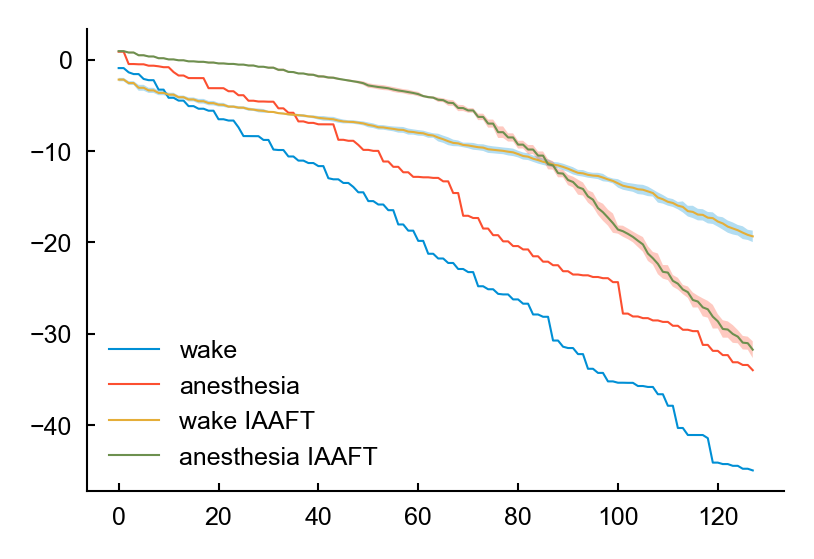

In [31]:
plt.plot(stab_params_w, label='wake')
plt.plot(stab_params_a, label='anesthesia')
if compute_iaaft:
    if isinstance(delase_w_iaaft, list):
        # plot with SEM
        plt.plot(stab_params_w_iaaft.mean(axis=0), label='wake IAAFT')
        plt.fill_between(np.arange(stab_params_w_iaaft.shape[1]), stab_params_w_iaaft.mean(axis=0) - stab_params_w_iaaft.std(axis=0), stab_params_w_iaaft.mean(axis=0) + stab_params_w_iaaft.std(axis=0), alpha=0.3)
        plt.plot(stab_params_a_iaaft.mean(axis=0), label='anesthesia IAAFT')
        plt.fill_between(np.arange(stab_params_a_iaaft.shape[1]), stab_params_a_iaaft.mean(axis=0) - stab_params_a_iaaft.std(axis=0), stab_params_a_iaaft.mean(axis=0) + stab_params_a_iaaft.std(axis=0), alpha=0.3)
    else:
        plt.plot(delase_w_iaaft.stability_params.cpu().numpy()[:int(top_percent*len(delase_w_iaaft.stability_params))], label='wake IAAFT')
        plt.plot(delase_a_iaaft.stability_params.cpu().numpy()[:int(top_percent*len(delase_a_iaaft.stability_params))], label='anesthesia IAAFT')
plt.legend()
plt.show()

In [32]:
awake_color = 'limegreen'
anesthesia_color = '#D65CD4'

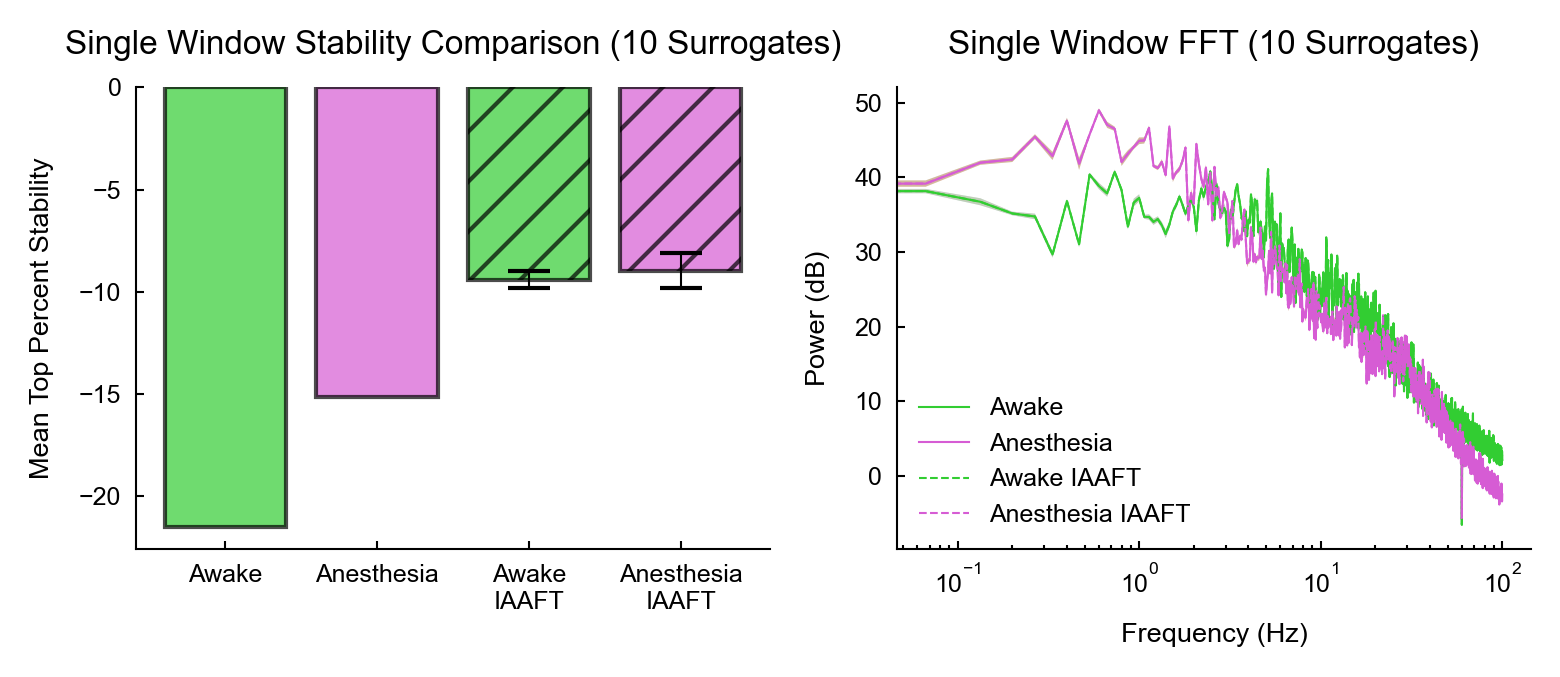

In [33]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(6, 2))

# Calculate means
ax = axs[0]
mean_stab_wake = stab_params_w.mean()
mean_stab_anesthesia = stab_params_a.mean()
mean_stab_wake_iaaft = stab_params_w_iaaft.mean(axis=1).mean()
mean_stab_anesthesia_iaaft = stab_params_a_iaaft.mean(axis=1).mean()

# Calculate SEMs for IAAFT
sem_stab_wake_iaaft = stab_params_w_iaaft.std(axis=1).mean() / np.sqrt(stab_params_w_iaaft.shape[1])
sem_stab_anesthesia_iaaft = stab_params_a_iaaft.std(axis=1).mean() / np.sqrt(stab_params_a_iaaft.shape[1])

# Prepare data for bar plot
means = [mean_stab_wake, mean_stab_anesthesia, mean_stab_wake_iaaft, mean_stab_anesthesia_iaaft]
sems = [np.nan, np.nan, sem_stab_wake_iaaft, sem_stab_anesthesia_iaaft]  # SEMs only for IAAFT
labels = ['Awake', 'Anesthesia', 'Awake\nIAAFT', 'Anesthesia\nIAAFT']

# Create bar plot
x = np.arange(len(labels))
bars = ax.bar(x, means, yerr=sems, capsize=5, color=['limegreen', '#D65CD4', 'limegreen', '#D65CD4'], alpha=0.7, edgecolor='black')

# Set hatch pattern for IAAFT bars
for i, bar in enumerate(bars):
    if 'IAAFT' in labels[i]:
        bar.set_hatch('//')

ax.set_xticks(x, labels)
ax.set_ylabel('Mean Top Percent Stability')
ax.set_title(f'Single Window Stability Comparison ({n_iaaft} Surrogates)')

ax = axs[1]

fft_lfp_w = np.fft.rfft(lfp_w, axis=0)
fft_lfp_a = np.fft.rfft(lfp_a, axis=0)
fft_lfp_w_iaaft = np.fft.rfft(lfp_w_iaaft, axis=1)
fft_lfp_a_iaaft = np.fft.rfft(lfp_a_iaaft, axis=1)
freqs = np.fft.rfftfreq(lfp_w.shape[0], d=dt)

min_freq = 0
max_freq = 100
freq_inds = (freqs >= min_freq) & (freqs <= max_freq)

from scipy.stats import sem

# Calculate means and SEMs

fft_lfp_w_db = 20*np.log10(np.abs(fft_lfp_w))
fft_lfp_a_db = 20*np.log10(np.abs(fft_lfp_a))
fft_lfp_w_iaaft_db = 20*np.log10(np.abs(fft_lfp_w_iaaft))
fft_lfp_a_iaaft_db = 20*np.log10(np.abs(fft_lfp_a_iaaft))

mean_wake = fft_lfp_w_db.mean(axis=-1)[freq_inds]
sem_wake = sem(fft_lfp_w_db, axis=-1)[freq_inds]

mean_anesthesia = fft_lfp_a_db.mean(axis=-1)[freq_inds]
sem_anesthesia = sem(fft_lfp_a_db, axis=-1)[freq_inds]

mean_wake_iaaft = fft_lfp_w_iaaft_db.mean(axis=-1)[:, freq_inds].mean(axis=0)
sem_wake_iaaft = sem(fft_lfp_w_iaaft_db, axis=-1)[:, freq_inds].mean(axis=0)

mean_anesthesia_iaaft = fft_lfp_a_iaaft_db.mean(axis=-1)[:, freq_inds].mean(axis=0)
sem_anesthesia_iaaft = sem(fft_lfp_a_iaaft_db, axis=-1)[:, freq_inds].mean(axis=0)

# Plot with fill_between for SEM
ax.plot(freqs[freq_inds], mean_wake, label='Awake', color='limegreen')
ax.fill_between(freqs[freq_inds], mean_wake - sem_wake, mean_wake + sem_wake, alpha=0.3)

ax.plot(freqs[freq_inds], mean_anesthesia, label='Anesthesia', color='#D65CD4')
ax.fill_between(freqs[freq_inds], mean_anesthesia - sem_anesthesia, mean_anesthesia + sem_anesthesia, alpha=0.3)

ax.plot(freqs[freq_inds], mean_wake_iaaft, label='Awake IAAFT', color='limegreen', linestyle='--')
ax.fill_between(freqs[freq_inds], mean_wake_iaaft - sem_wake_iaaft, mean_wake_iaaft + sem_wake_iaaft, alpha=0.3)

ax.plot(freqs[freq_inds], mean_anesthesia_iaaft, label='Anesthesia IAAFT', color='#D65CD4', linestyle='--')
ax.fill_between(freqs[freq_inds], mean_anesthesia_iaaft - sem_anesthesia_iaaft, mean_anesthesia_iaaft + sem_anesthesia_iaaft, alpha=0.3)
# plt.yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB)')
ax.set_title(f'Single Window FFT ({n_iaaft} Surrogates)')
plt.show()

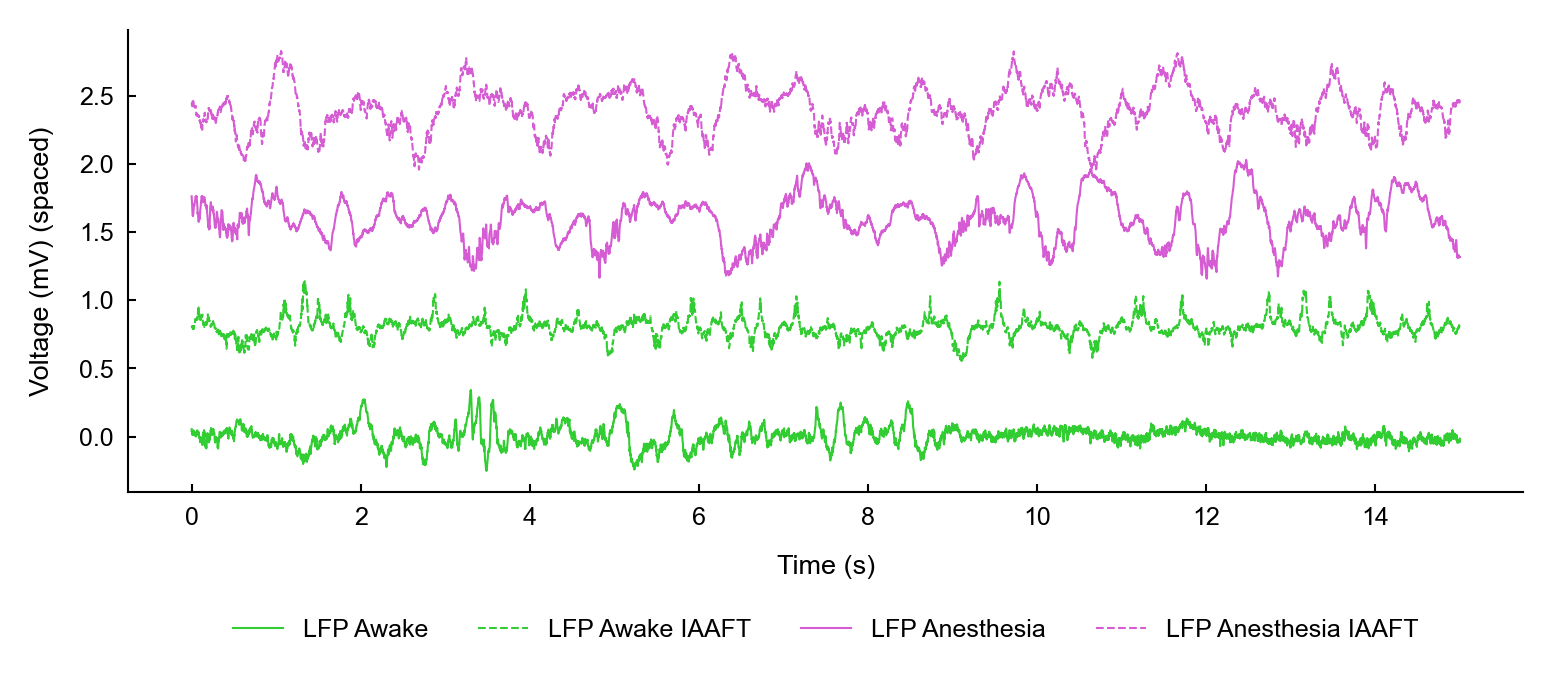

In [186]:
fig = plt.figure(figsize=(6, 2))

offset = 0.8  # Define an offset value to separate the curves vertically


plt.plot(np.arange(lfp_w.shape[0])*dt, lfp_w[:, 0], label='LFP Awake', color='limegreen')
plt.plot(np.arange(lfp_w_iaaft.shape[-2])*dt, lfp_w_iaaft[0,:, 0] + offset, label='LFP Awake IAAFT', color='limegreen', linestyle='--')
plt.plot(np.arange(lfp_a.shape[0])*dt, lfp_a[:, 0] + 2 * offset, label='LFP Anesthesia', color='#D65CD4')
plt.plot(np.arange(lfp_a_iaaft.shape[-2])*dt, lfp_a_iaaft[0,:, 0] + 3 * offset, label='LFP Anesthesia IAAFT', color='#D65CD4', linestyle='--')

plt.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=4)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV) (spaced)')

plt.show()

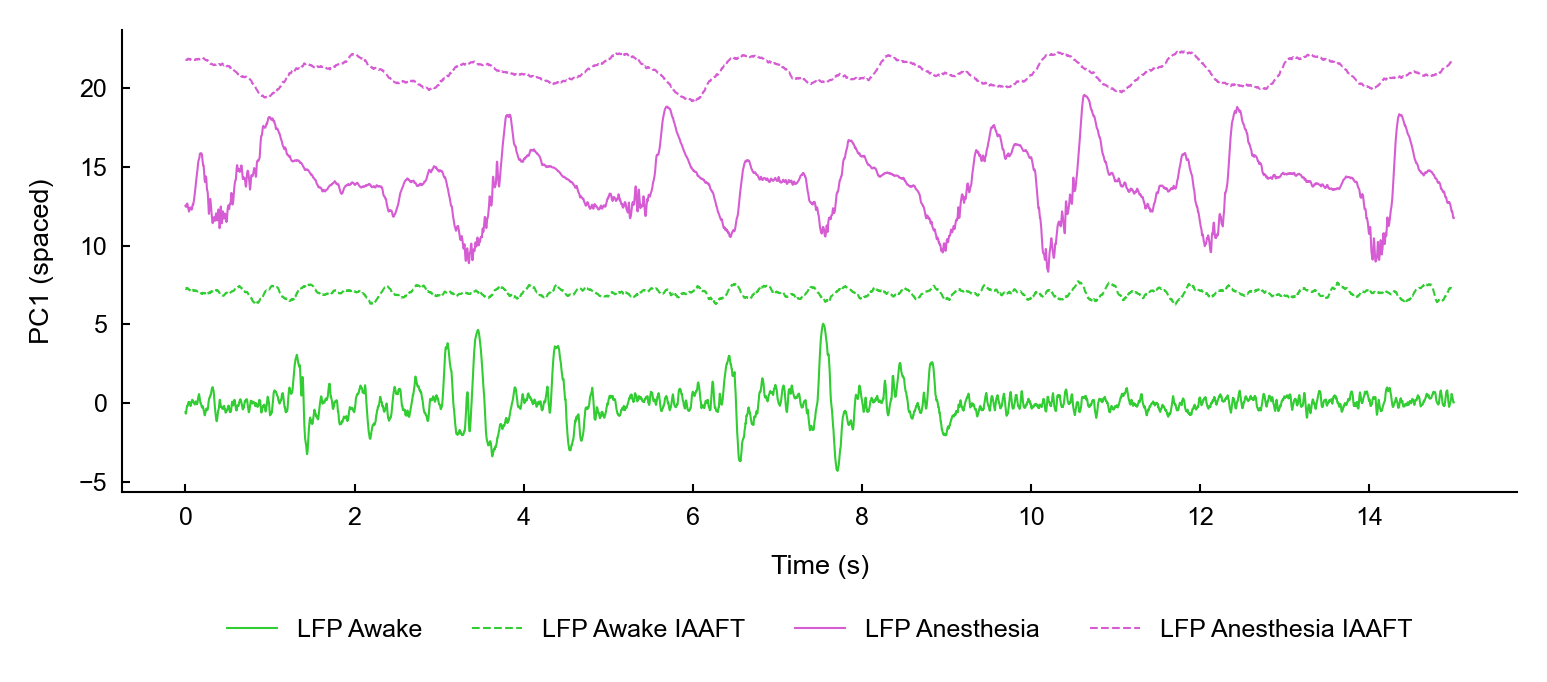

In [182]:
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(6, 2))

offset = 7  # Define an offset value to separate the curves vertically

lfp_w_pca = PCA(n_components=2).fit_transform(lfp_w)
lfp_a_pca = PCA(n_components=2).fit_transform(lfp_a)
lfp_w_iaaft_pca = PCA(n_components=2).fit_transform(lfp_w_iaaft[0])
lfp_a_iaaft_pca = PCA(n_components=2).fit_transform(lfp_a_iaaft[0])


plt.plot(np.arange(lfp_w_pca.shape[0])*dt, lfp_w_pca[:, 0], label='LFP Awake', color='limegreen')
plt.plot(np.arange(lfp_w_iaaft_pca.shape[0])*dt, lfp_w_iaaft_pca[:, 0] + offset, label='LFP Awake IAAFT', color='limegreen', linestyle='--')
plt.plot(np.arange(lfp_a_pca.shape[0])*dt, lfp_a_pca[:, 0] + 2 * offset, label='LFP Anesthesia', color='#D65CD4')
plt.plot(np.arange(lfp_a_iaaft_pca.shape[0])*dt, lfp_a_iaaft_pca[:, 0] + 3 * offset, label='LFP Anesthesia IAAFT', color='#D65CD4', linestyle='--')

plt.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=4)
plt.xlabel('Time (s)')
plt.ylabel('PC1 (spaced)')

plt.show()

# DEX TESTING

In [9]:
# all_data_dir = '/orcd/data/ekmiller/001/common/datasets'
# data_class = 'propofolPuffTone'
data_class = 'anesthesiaLvrOdd'

data_dir = os.path.join(cfg.params.all_data_dir, data_class, 'mat')
cfg.params.data_class = 'anesthesiaLvrOdd'
cfg.params.grid_set = 'grid_set4'

In [10]:
session_high = "PEDRI_Dexmedetomidine_20220324"
session_low = "PEDRI_Dexmedetomidine_20220419"

In [13]:
session_details = {}

for session in [session_high, session_low]:
    session_details[session] = {}

    noise_filter_info = {}
    if cfg.params.noise_filter:
        os.makedirs(cfg.params.noise_filter_results_dir, exist_ok=True)
        noise_filter_dir = os.path.join(cfg.params.noise_filter_results_dir, cfg.params.data_class)
        os.makedirs(noise_filter_dir, exist_ok=True)
        noise_filter_file = f"{session}__window_{cfg.params.window}__wakethresh_{cfg.params.wake_amplitude_thresh}__anesthesiathresh_{cfg.params.anesthesia_amplitude_thresh}__electrodenum_{cfg.params.electrode_num_thresh}.pkl"
        
        print("--------------------")
        print(f"Session: {session}")
        print("--------------------")
        if noise_filter_file in os.listdir(noise_filter_dir):
            noise_filter_info[session] = pd.read_pickle(os.path.join(noise_filter_dir, noise_filter_file))
        else:
            print("Finding noisy data...")
            window_df, bad_electrodes, valid_window_starts = find_noisy_data(cfg, session)
            noise_filter_info[session] = dict(
                window_df=window_df,
                bad_electrodes=bad_electrodes,
                valid_window_starts=valid_window_starts
            )
            pd.to_pickle(noise_filter_info[session], os.path.join(noise_filter_dir, noise_filter_file))
        
        print(f"{len(noise_filter_info[session]['bad_electrodes'])} bad electrodes, {len(noise_filter_info[session]['valid_window_starts'])} valid windows (out of {len(noise_filter_info[session]['window_df'])} total windows)")
    else:
        bad_electrodes = []
        valid_window_starts = None
        noise_filter_info = dict(
            window_df=None,
            bad_electrodes=bad_electrodes,
            valid_window_starts=valid_window_starts
        )
    
    session_details[session]['noise_filter_info'] = noise_filter_info
    
    session_file = h5py.File(os.path.join(data_dir,f"{session}.mat"), 'r')

    lfp = TransposedDatasetView(session_file['lfp']).transpose()
    dt = session_file['lfpSchema']['smpInterval'][0, 0]
    if data_class == 'propofolPuffTone':
        infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
    else:
        infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]

    wake_t = (infusion_start - 10*60) # MrJones
    anesthesia_t = (infusion_start + 20*60) # MrJones

    # wake_t = (infusion_start - 10*60) 
    # anesthesia_t = (infusion_start + 45*60) 

    wake_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(wake_t - noise_filter_info[session]['valid_window_starts']))]
    anesthesia_window_start = noise_filter_info[session]['valid_window_starts'][np.argmin(np.abs(anesthesia_t - noise_filter_info[session]['valid_window_starts']))]

    bad_electrodes = noise_filter_info[session]['bad_electrodes']
    valid_electrodes = [i for i in range(lfp.shape[1]) if i not in bad_electrodes]
    window = 15
    lfp_w = lfp[int(wake_window_start/dt):int((wake_window_start + window)/dt), valid_electrodes]
    lfp_a = lfp[int(anesthesia_window_start/dt):int((anesthesia_window_start + window)/dt), valid_electrodes]

    session_details[session]['lfp_w'] = lfp_w
    session_details[session]['lfp_a'] = lfp_a

    session_details[session]['bad_electrodes'] = bad_electrodes

    electrode_areas = convert_h5_string_array(session_file, session_file['electrodeInfo']['area'][0, :])
    session_details[session]['electrode_areas'] = electrode_areas
    

--------------------
Session: PEDRI_Dexmedetomidine_20220324
--------------------
12 bad electrodes, 1301 valid windows (out of 1353 total windows)
--------------------
Session: PEDRI_Dexmedetomidine_20220419
--------------------
14 bad electrodes, 802 valid windows (out of 873 total windows)


In [14]:
areas = ['all']
# areas = ['vlPFC']
pca_chosen = None

session_list = [session_high, session_low]

In [15]:
grid_params_to_use, grid_search_results = get_grid_params_to_use(cfg, session_list, areas, pca_chosen, log=None, return_results=True, verbose=True)

--------------------
SESSION = PEDRI_Dexmedetomidine_20220324
--------------------
list exists! loading /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/PEDRI_Dexmedetomidine_20220324_grid_set4_window_15...
Loading data for PEDRI_Dexmedetomidine_20220324 - all


  0%|          | 0/800 [00:00<?, ?it/s]

--------------------
SESSION = PEDRI_Dexmedetomidine_20220419
--------------------
list exists! loading /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/grid_searches/anesthesiaLvrOdd/grid_search_run_lists/PEDRI_Dexmedetomidine_20220419_grid_set4_window_15...
Loading data for PEDRI_Dexmedetomidine_20220419 - all


  0%|          | 0/800 [00:00<?, ?it/s]

Results for session: PEDRI_Dexmedetomidine_20220324, area: all: n_delays=8, rank=900
Results for session: PEDRI_Dexmedetomidine_20220419, area: all: n_delays=9, rank=1000


Using grid params from session PEDRI_Dexmedetomidine_20220324: n_delays = 8, rank = 900


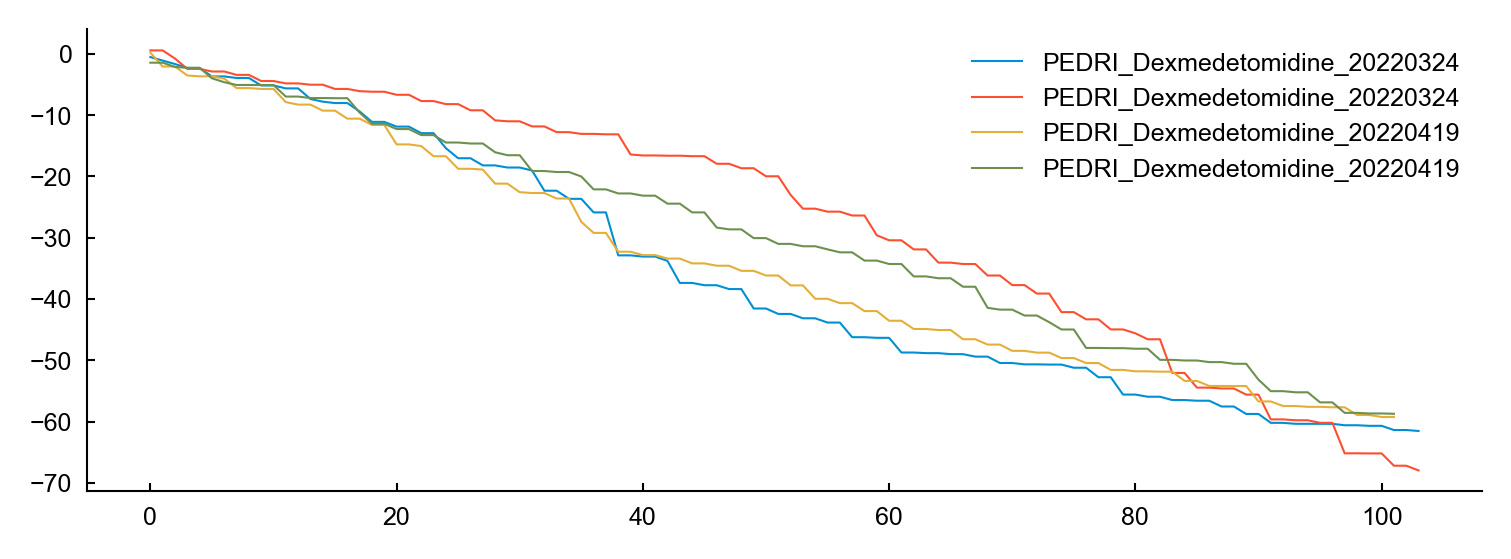

Using grid params from session PEDRI_Dexmedetomidine_20220419: n_delays = 9, rank = 1000


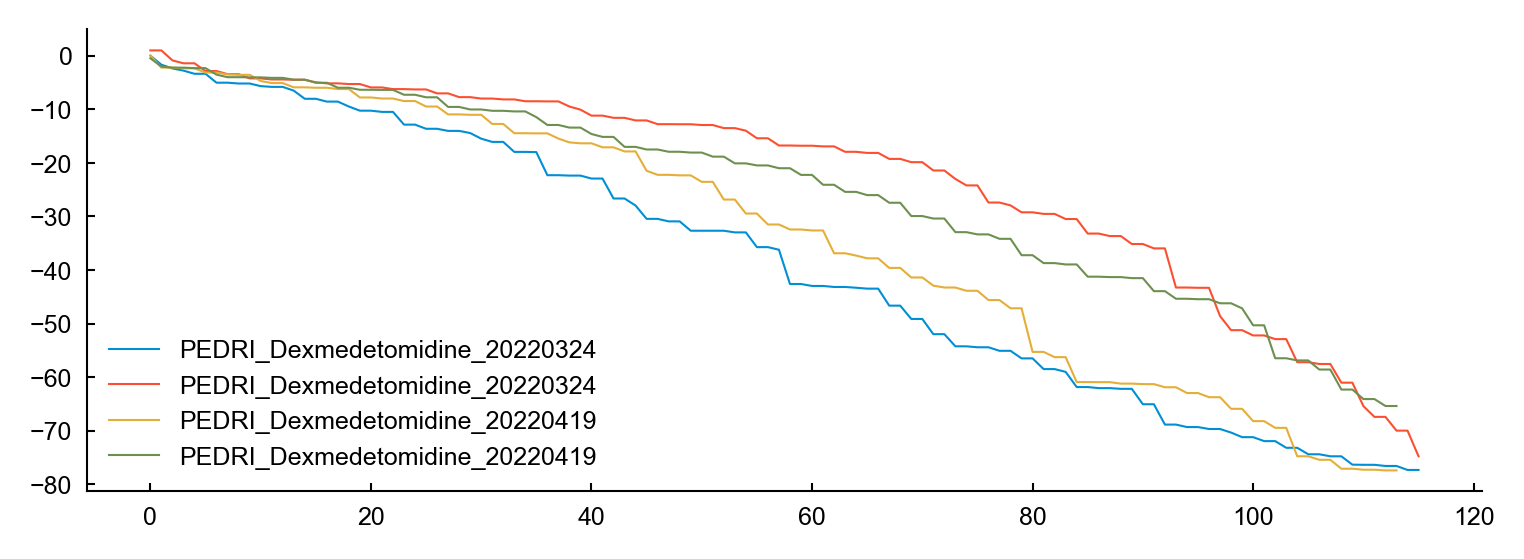

In [18]:
top_percent = 0.1
for session in session_list:
    n_delays = grid_params_to_use[session][areas[0]]['n_delays']
    rank = grid_params_to_use[session][areas[0]]['rank']

    print(f"Using grid params from session {session}: n_delays = {n_delays}, rank = {rank}")

    delases = {}
    plt.figure(figsize=(6, 2))
    for session in session_list:
        delases[session] = {}
        delases[session]['w'] = DeLASE(session_details[session]['lfp_w'], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
        delases[session]['a'] = DeLASE(session_details[session]['lfp_a'], n_delays=n_delays, rank=rank, dt=dt, max_freq=cfg.params.max_freq, max_unstable_freq=cfg.params.max_unstable_freq, device='cuda')
        delases[session]['w'].fit()
        delases[session]['a'].fit()

        plt.plot(delases[session]['w'].stability_params.cpu().numpy()[:int(top_percent*len(delases[session]['w'].stability_params))], label=session)
        plt.plot(delases[session]['a'].stability_params.cpu().numpy()[:int(top_percent*len(delases[session]['a'].stability_params))], label=session)
    plt.legend()
    plt.show()

